seawat_henry.nam


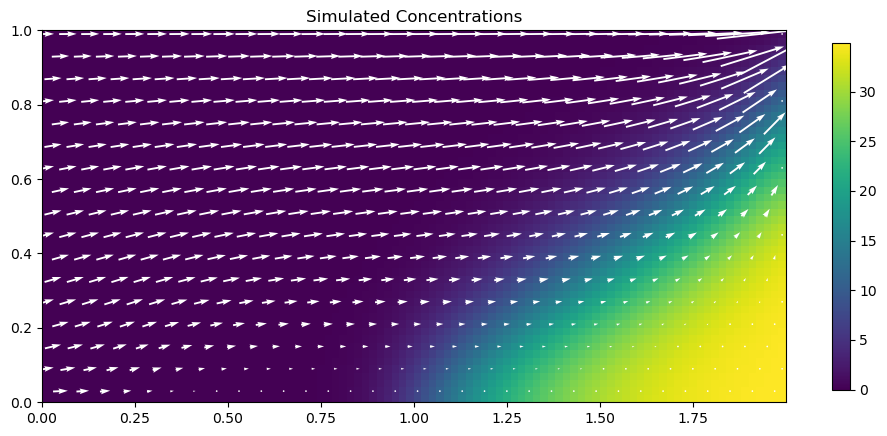

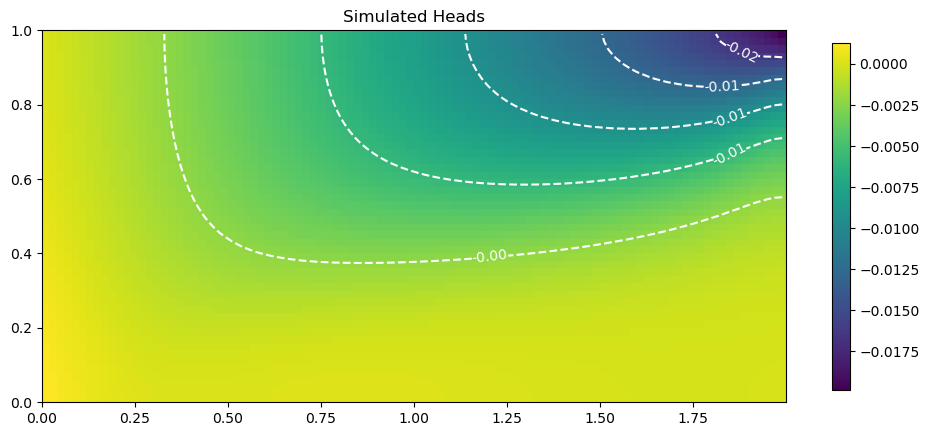

In [1]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.5.1
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
#   metadata:
#     section: mt3dms
# ---

# # SEAWAT Tutorial 1: Henry Saltwater Intrusion Problem
#
# In this tutorial, we will use Flopy to create, run, and post process the
# Henry saltwater intrusion problem using SEAWAT Version 4.

# ## Getting Started
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np

import flopy

# ### Input variables for the Henry Problem

Lx = 2.0
Lz = 1.0
nlay = 50
nrow = 1
ncol = 100
delr = Lx / ncol
delc = 1.0
delv = Lz / nlay
henry_top = 1.0
henry_botm = np.linspace(henry_top - delv, 0.0, nlay)
qinflow = 5.702  # m3/day
dmcoef = 0.57024  # m2/day  Could also try 1.62925 as another case of the Henry problem
hk = 864.0  # m/day

# ### Create the basic MODFLOW model structure

temp_dir = TemporaryDirectory()
workspace = temp_dir.name
name = "seawat_henry"
swt = flopy.seawat.Seawat(name, exe_name="swtv4", model_ws=workspace)
print(swt.namefile)

# save cell fluxes to unit 53

ipakcb = 53

# Add DIS package to the MODFLOW model

dis = flopy.modflow.ModflowDis(
    swt,
    nlay,
    nrow,
    ncol,
    nper=1,
    delr=delr,
    delc=delc,
    laycbd=0,
    top=henry_top,
    botm=henry_botm,
    perlen=1.5,
    nstp=15,
)

# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, -1] = -1

# Add BAS package to the MODFLOW model

bas = flopy.modflow.ModflowBas(swt, ibound, 0)

# Add LPF package to the MODFLOW model

lpf = flopy.modflow.ModflowLpf(swt, hk=hk, vka=hk, ipakcb=ipakcb)

# Add PCG Package to the MODFLOW model

pcg = flopy.modflow.ModflowPcg(swt, hclose=1.0e-8)

# Add OC package to the MODFLOW model

oc = flopy.modflow.ModflowOc(
    swt,
    stress_period_data={(0, 0): ["save head", "save budget"]},
    compact=True,
)

# Create WEL and SSM data

itype = flopy.mt3d.Mt3dSsm.itype_dict()
wel_data = {}
ssm_data = {}
wel_sp1 = []
ssm_sp1 = []
for k in range(nlay):
    wel_sp1.append([k, 0, 0, qinflow / nlay])
    ssm_sp1.append([k, 0, 0, 0.0, itype["WEL"]])
    ssm_sp1.append([k, 0, ncol - 1, 35.0, itype["BAS6"]])
wel_data[0] = wel_sp1
ssm_data[0] = ssm_sp1
wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)

# ### Create the basic MT3DMS model structure

btn = flopy.mt3d.Mt3dBtn(
    swt,
    nprs=-5,
    prsity=0.35,
    sconc=35.0,
    ifmtcn=0,
    chkmas=False,
    nprobs=10,
    nprmas=10,
    dt0=0.001,
)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=0.0, trpt=1.0, trpv=1.0, dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(swt, stress_period_data=ssm_data)

# ### Create the SEAWAT model structure

vdf = flopy.seawat.SeawatVdf(
    swt,
    iwtable=0,
    densemin=0,
    densemax=0,
    denseref=1000.0,
    denseslp=0.7143,
    firstdt=1e-3,
)

# ## Write the input files

swt.write_input()

# ## Run the model

success, buff = swt.run_model(silent=True, report=True)
assert success, "SEAWAT did not terminate normally."

# ## Post-process the results

import numpy as np

import flopy.utils.binaryfile as bf

# ### Load the concentration data

ucnobj = bf.UcnFile(Path(workspace) / "MT3D001.UCN", model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])

# ### Load the cell-by-cell flow data

cbbobj = bf.CellBudgetFile(Path(workspace) / f"{name}.cbc")
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times[-1])[0]
qy = np.zeros((nlay, nrow, ncol), dtype=float)
qz = cbbobj.get_data(text="flow lower face", totim=times[-1])[0]

# ### Create a plot with concentrations and flow vectors

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotCrossSection(model=swt, ax=ax, line={"row": 0})
arr = pmv.plot_array(concentration)
pmv.plot_vector(qx, qy, -qz, color="white", kstep=3, hstep=3)
plt.colorbar(arr, shrink=0.5, ax=ax)
ax.set_title("Simulated Concentrations")

# ### Load the head data

headobj = bf.HeadFile(Path(workspace) / f"{name}.hds")
times = headobj.get_times()
head = headobj.get_data(totim=times[-1])

# ### Create a plot with heads

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotCrossSection(model=swt, ax=ax, line={"row": 0})
arr = pmv.plot_array(head)
contours = pmv.contour_array(head, colors="white")
ax.clabel(contours, fmt="%2.2f")
plt.colorbar(arr, shrink=0.5, ax=ax)
ax.set_title("Simulated Heads")

try:
    temp_dir.cleanup()
except:
    # prevent windows permission error
    pass
